In [19]:
import sys
sys.path.append('/content/CppToPython')
import numpy as np
import GeDiM4Py as gedim
import math as mt

lib = gedim.ImportLibrary("/content/CppToPython/release/GeDiM4Py.so")

config = { 'GeometricTolerance': 1.0e-8 }
gedim.Initialize(config, lib)

In [20]:

def Progetto_a(numPoints, points):
	values_a = np.ones(numPoints, order='F')
	return values_a.ctypes.data

def Progetto_b(numPoints, points):
	values_b = (mu_0/mu_1)*np.ones((2, numPoints), order='F')
	return values_b.ctypes.data

def Progetto_c(numPoints, points):
	values_c = np.ones(numPoints, order='F')
	return values_c.ctypes.data

'''def Progetto_non_linear_b(numPoints, points, u, u_x, u_y):
	vecu = gedim.make_nd_array(u, numPoints, np.double)
	values_nl_b = vecu
	return values_nl_b.ctypes.data'''

def Progetto_non_linear_c(numPoints, points, u, u_x, u_y):
	vecu = gedim.make_nd_array(u, numPoints, np.double)
	values_nl_c = mu_0*np.exp(mu_1*vecu)
	return values_nl_c.ctypes.data

def Progetto_f(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values_f = 32.0 * (matPoints[1,:] * (1.0 - matPoints[1,:]) + matPoints[0,:] * (1.0 - matPoints[0,:])) + \
	mu_0/mu_1*(np.exp(mu_1*16.0 * (matPoints[1,:] * (1.0 - matPoints[1,:]) * matPoints[0,:] * (1.0 - matPoints[0,:])))-1)
	return values_f.ctypes.data


def Progetto_g(numPoints, points):
    matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
    values_g = np.zeros(numPoints)
    for i in range(numPoints):
        values_g[i] = 100*mt.sin(2*mt.pi*matPoints[0,i])*mt.cos(2*mt.pi*matPoints[1,i])
    return values_g.ctypes.data


def Progetto_non_linear_f(numPoints, points, u, u_x, u_y):
	vecu = gedim.make_nd_array(u, numPoints, np.double)
	values_nl_f = mu_0/mu_1*np.exp(mu_1*vecu)-mu_0/mu_1
	return values_nl_f.ctypes.data

def Progetto_non_linear_der_f(numPoints, points, u, u_x, u_y):
	vecu_x = gedim.make_nd_array(u_x, numPoints, np.double)
	vecu_y = gedim.make_nd_array(u_y, numPoints, np.double)
	values_nl_d_f = np.zeros((2, numPoints), order='F')
	values_nl_d_f[0,:] = vecu_x
	values_nl_d_f[1,:] = vecu_y
	return values_nl_d_f.ctypes.data

def Progetto_exactSolution(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values_ex = 16.0 * (matPoints[1,:] * (1.0 - matPoints[1,:]) * matPoints[0,:] * (1.0 - matPoints[0,:]))
	return values_ex.ctypes.data

def Progetto_exactDerivativeSolution(direction, numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)

	if direction == 0:
		values_ex_d = 16.0 * (1.0 - 2.0 * matPoints[0,:]) * matPoints[1,:] * (1.0 - matPoints[1,:])
	elif direction == 1:
		values_ex_d = 16.0 * (1.0 - 2.0 * matPoints[1,:]) * matPoints[0,:] * (1.0 - matPoints[0,:])
	else:
		values_ex_d = np.zeros(numPoints, order='F')

	return values_ex_d.ctypes.data

def Ones(numPoints, points):
	values_one = np.ones(numPoints, order='F')
	return values_one.ctypes.data

def OnesDerivative(numPoints, points):
	values_one_d = np.ones((2, numPoints), order='F')
	return values_one_d.ctypes.data

def Zeros(numPoints, points):
	values_zero = np.zeros(numPoints, order='F')
	return values_zero.ctypes.data

def ZerosDerivative(direction, numPoints, points):
	values_zero_d = np.zeros(numPoints, order='F')
	return values_zero_d.ctypes.data

In [21]:
meshSize = 0.001
order = 1

domain = { 'SquareEdge': 1.0, 'VerticesBoundaryCondition': [1,1,1,1], 'EdgesBoundaryCondition': [1,1,1,1], 'DiscretizationType': 1, 'MeshCellsMaximumArea': meshSize }
[meshInfo, mesh] = gedim.CreateDomainSquare(domain, lib)



## FEM Space (High Fidelity approximation)

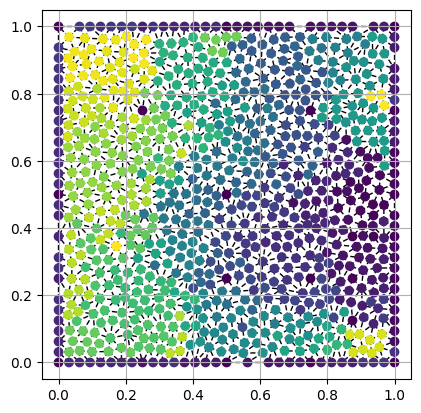

(3, 713)


In [22]:
discreteSpace = { 'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 2] }
[problemData, dofs, strongs] = gedim.Discretize(discreteSpace, lib)

gedim.PlotDofs(mesh,dofs,strongs)
print(dofs.shape)

In [23]:
residual_norm = 1.0
solution_norm = 1.0;
newton_tol = 1.0e-6
max_iterations = 7
num_iteration = 1

In [24]:
mu_0 = 0.5
mu_1 = 0.1

u_k = np.zeros(problemData['NumberDOFs'], order='F')    # full solution
u_strong = np.zeros(problemData['NumberStrongs'], order='F')
while num_iteration < max_iterations: 
    [stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Progetto_a, problemData, lib)
    [reaction, reactionStrong] = gedim.AssembleNonLinearReactionMatrix(Progetto_c, Progetto_non_linear_c, u_k, u_strong, problemData, lib)

    forcingTerm_g = gedim.AssembleForcingTerm(Progetto_g, problemData, lib)
    forcingTerm_v = gedim.AssembleNonLinearForcingTerm(Ones, Progetto_non_linear_f, u_k, u_strong, problemData, lib)
    forcingTerm_der_v = gedim.AssembleNonLinearDerivativeForcingTerm(OnesDerivative, Progetto_non_linear_der_f, u_k, u_strong, problemData, lib)
    
    du = gedim.LUSolver(stiffness + reaction, \
            forcingTerm_g - forcingTerm_v - forcingTerm_der_v, \
            lib)
    
    u_k = u_k + du

    print("dofs", "h", "iteration", "max_iteration")
    print(problemData['NumberDOFs'], '{:.16e}'.format(problemData['H']), '{:d}'.format(num_iteration), '{:d}'.format(max_iterations))
    
    num_iteration = num_iteration + 1

dofs h iteration max_iteration
713 6.4341029499729044e-02 1 7
dofs h iteration max_iteration
713 6.4341029499729044e-02 2 7
dofs h iteration max_iteration
713 6.4341029499729044e-02 3 7
dofs h iteration max_iteration
713 6.4341029499729044e-02 4 7
dofs h iteration max_iteration
713 6.4341029499729044e-02 5 7
dofs h iteration max_iteration
713 6.4341029499729044e-02 6 7


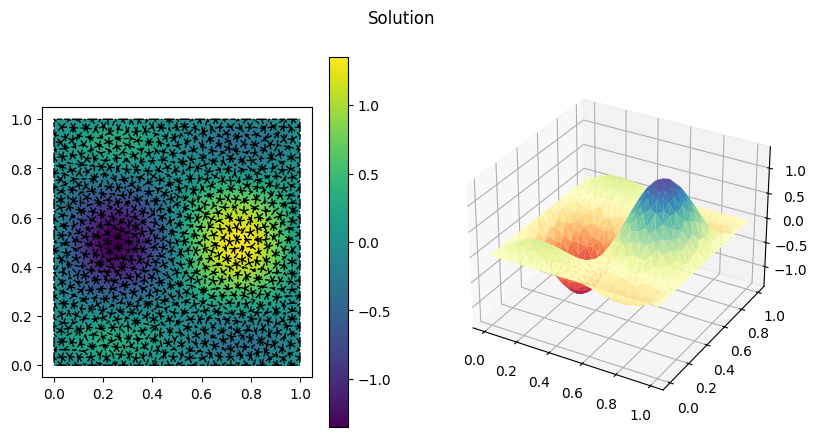

In [25]:
gedim.PlotSolution(mesh, dofs, strongs, u_k, u_strong)
gedim.ExportSolution(Progetto_exactSolution, u_k, u_strong, lib)

[numQuadraturePoints, quadraturePoints, quadratureWeights, sol, sol_x, sol_y] = gedim.EvaluateSolutionOnPoints(u_k, u_strong, lib)
gedim.ExportSolutionOnPoints(numQuadraturePoints, quadraturePoints, sol, lib)

# POD

## Offline phase 

In [26]:
inner_product = stiffness

In [27]:
### define the training set

snapshot_num = 100 
mu0_range = [0.1, 1.]
mu1_range = [0.1, 1.]
P = np.array([mu0_range, mu1_range])

training_set = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(snapshot_num, P.shape[0]))
print(P.shape[0])

2


In [28]:
#### snapshot matrix creation
thetaA1 = 1
snapshot_matrix = []


tol = 1. - 1e-7
N_max = 10

u_k_red = np.zeros(problemData['NumberDOFs'], order='F')    # reduced solution
u_strong_red = np.zeros(problemData['NumberStrongs'], order='F')

for mu in training_set:
    mu_0 = mu[0]
    mu_1 = mu[1]
    num_iteration = 1
    while num_iteration < max_iterations: 
        [stiffness_red, stiffnessStrong_red] = gedim.AssembleStiffnessMatrix(Progetto_a, problemData, lib)
        [reaction_red, reactionStrong_red] = gedim.AssembleNonLinearReactionMatrix(Progetto_c, Progetto_non_linear_c, u_k_red, u_strong_red, problemData, lib)
    
        forcingTerm_g_red = gedim.AssembleForcingTerm(Progetto_g, problemData, lib)
        forcingTerm_v_red = gedim.AssembleNonLinearForcingTerm(Ones, Progetto_non_linear_f, u_k_red, u_strong_red, problemData, lib)
        forcingTerm_der_v_red = gedim.AssembleNonLinearDerivativeForcingTerm(OnesDerivative, Progetto_non_linear_der_f, u_k_red, u_strong_red, problemData, lib)
        
        du_red = gedim.LUSolver(stiffness_red + reaction_red, \
                forcingTerm_g_red - forcingTerm_v_red - forcingTerm_der_v_red, \
                lib)
        u_k_red = u_k_red + du_red
        
        #print("dofs", "h", "iteration", "max_iteration")
        #print(problemData['NumberDOFs'], '{:.16e}'.format(problemData['H']), '{:d}'.format(num_iteration), '{:d}'.format(max_iterations))
        
        num_iteration = num_iteration + 1
    snapshot = u_k_red
    snapshot_matrix.append(np.copy(snapshot))
    
snapshot_matrix = np.array(snapshot_matrix) 
#print(snapshot_matrix.shape)# 100 valori diversi dei parametri (M=100), su ogni riga ho la soluzione per un determinato parametro valutata nei 713 nodi interni
#print(snapshot_matrix)

In [29]:
### covariance matrix

C = snapshot_matrix @ inner_product @ np.transpose(snapshot_matrix) 

###### shape?? ############

#### ALTERNATIVE:  VM, L, VMt = np.linalg.svd((C))

L_e, VM_e = np.linalg.eig(C)
eigenvalues = []
eigenvectors = []


#### check


for i in range(len(L_e)):
  eig_real = L_e[i].real
  eig_complex = L_e[i].imag
  assert np.isclose(eig_complex, 0.)
  eigenvalues.append(eig_real)
  eigenvectors.append(VM_e[i].real)


total_energy = sum(eigenvalues)
retained_energy_vector = np.cumsum(eigenvalues)
relative_retained_energy = retained_energy_vector/total_energy


if all(flag==False for flag in relative_retained_energy>= tol):
  N = N_max
else:
  N = np.argmax(relative_retained_energy >= tol) + 1

print("The reduced dimension is", N)

print(eigenvalues)


The reduced dimension is 3
[2102.2933925247944, 0.012792929953558676, 0.0014215761210080757, 7.624424154777129e-07, 8.452791110569942e-08, 8.128215108708191e-10, 3.9056178103524783e-10, 3.5192038931703204e-11, 1.909989640766957e-13, 1.1315573266321348e-13, 1.1315573266321348e-13, 3.496681939450482e-14, 3.496681939450482e-14, -1.95695105624931e-14, -1.95695105624931e-14, -2.5284968694628008e-14, -2.5284968694628008e-14, 5.5239676316650466e-14, 5.5239676316650466e-14, 5.5737576624253893e-14, 5.5737576624253893e-14, -7.774509334860106e-15, -7.774509334860106e-15, 2.5895115622692737e-14, 2.5895115622692737e-14, -4.877349997934135e-14, -4.877349997934135e-14, 1.6147801332078383e-14, 1.6147801332078383e-14, 4.873777789351185e-14, 4.873777789351185e-14, -5.506365291749602e-14, -5.506365291749602e-14, 4.350481918230312e-14, 4.350481918230312e-14, 1.071187530285839e-14, 1.071187530285839e-14, -2.0104916234649866e-14, -2.0104916234649866e-14, -4.21240839655734e-14, -4.21240839655734e-14, -4.8902

In [30]:
# Create the basis function matrix
basis_functions = []
for n in range(N):
  eigenvector =  eigenvectors[n]
  
  # basis = (1/np.sqrt(snapshot_num))*np.transpose(snapshot_matrix)@eigenvector  (This is the one of the book!!)
  
  basis = np.transpose(snapshot_matrix)@eigenvector
  norm = np.sqrt(np.transpose(basis) @ inner_product @ basis) 
  
  basis /= norm
  basis_functions.append(np.copy(basis))

basis_functions = np.transpose(np.array(basis_functions))

In [31]:
########## ASSEMBLE THE LINEAR SYSTEM ##### STILL OFFLINE
reduced_stiffness = np.transpose(basis_functions) @ stiffness_red @ basis_functions
reduced_reaction = np.transpose(basis_functions) @ reaction_red @ basis_functions
reduced_g =  np.transpose(basis_functions) @ forcingTerm_g_red
reduced_v =  np.transpose(basis_functions) @ forcingTerm_v_red
reduced_der_v =  np.transpose(basis_functions) @ forcingTerm_der_v_red
### shape? ##### 

# Online phase

In [32]:
mu_0 = mu[0]
mu_1 = mu[1]

reduced_rhs = reduced_stiffness + reduced_reaction
reduced_lhs = reduced_g - reduced_v - reduced_der_v

##### solve ######### 

reduced_solution = np.linalg.solve(reduced_rhs, reduced_lhs)
# print(reduced_solution)

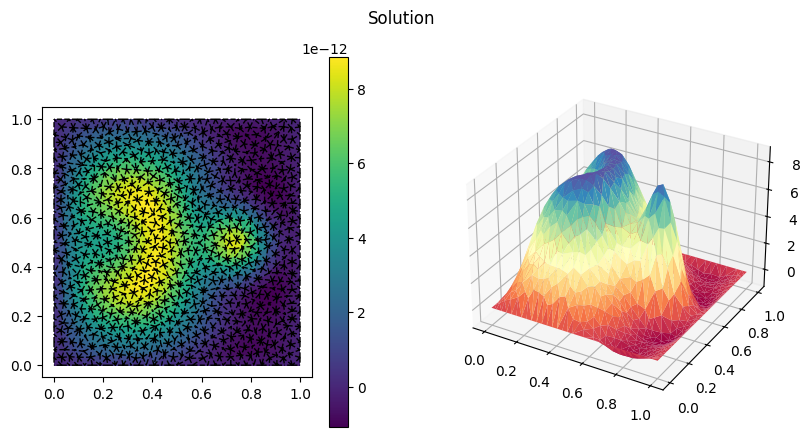

In [33]:
###### plot #######
proj_reduced_solution = basis_functions @ reduced_solution

gedim.PlotSolution(mesh, dofs, strongs, proj_reduced_solution, np.zeros(problemData['NumberStrongs']))

In [34]:
### compute error
import time

abs_err = []
rel_err = []
testing_set = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(100, P.shape[0]))
speed_up = []

print("Computing error and speedup analysis")

for mu in testing_set:
  
  mu_0 = mu[0]
  mu_1 = mu[1]  
  
  proj_reduced_solution = basis_functions@reduced_solution

  ### computing error

  error_function = u_k - proj_reduced_solution
  error_norm_squared_component = np.transpose(error_function) @ inner_product @ error_function
  absolute_error = np.sqrt(abs(error_norm_squared_component))
  abs_err.append(absolute_error)
  
  full_solution_norm_squared_component = np.transpose(u_k) @  inner_product @ u_k
  relative_error = absolute_error/np.sqrt(abs(full_solution_norm_squared_component))
  rel_err.append(relative_error)

Computing error and speedup analysis


In [35]:
print("avarege relative error = ", np.mean(rel_err) )
print("avarege absolute error = ", np.mean(abs_err) )

avarege relative error =  1.0000000000000193
avarege absolute error =  4.587668671805354
